In [2]:
import numpy as np
import pandas as pd

import os

import pydicom as pydi
import cv2

import matplotlib.pyplot as plt

from utils.preprocessing import image_preprocessing

In [3]:
descript_base_dir = "/mnt/data1/OAICompleteData_ASCII/"
image_base = "/mnt/data1/OAI/00m/results/"
mri_file_str = "MRI{mo}.txt"
visit_str = "{0:0=2d}"

In [4]:
def filter_by_view(enrollee_pth, mri_pth, visit_id, view_query="SAG"):
    mri_info = pd.read_csv(mri_pth, sep="|")
    enrollees = pd.read_csv(enrollee_pth, sep="|")
    
    # Column name formatters
    view_col = "V{id}MEXAMTP".format(id=visit_id)
    date_col = "V{id}MRDATE".format(id=visit_id)
    
    unique_views = [view for view in mri_info[view_col].unique() if view_query in view]
    filtered = mri_info[mri_info[view_col].isin(unique_views)]
    joined_set = enrollees.merge(filtered, on='ID', how='right')
    joined_set[date_col] = pd.to_datetime(joined_set[date_col], infer_datetime_format=True)
    return joined_set

In [5]:
def retrieve_mri(pid, cohort, time, visit_id, mri_barcode):
    slices = []
    mri_pth = "/mnt/data1/OAI/{vid}m/results/{visit}.{cohort}/{pid}/{date}/{barcode}/"
    mri_formatted_pth = mri_pth.format(vid=visit_str.format(visit_id), visit=visit_id, cohort=cohort, pid=pid, 
                                 date=time, barcode=mri_barcode)

    # Preprocessing
    for slice_num in os.listdir(mri_formatted_pth):
        slice_pth = os.path.join(mri_formatted_pth, slice_num)
        img, data, img_before = image_preprocessing(slice_pth)
        slices.append(img)
    
    return slices

In [6]:
filtered = filter_by_view(descript_base_dir + "Enrollees.txt", descript_base_dir + "MRI00.txt", "00")

In [7]:
# Filter patients

counter = 0
for i, row in filtered.iterrows():
    if counter == 0:
        break 
        
    cohort = "C.2" if row["V00CHRTHLF"]== "1: First half of cohort" else "E.1" if row["V00CHRTHLF"] == "2: Second half of cohort" else np.nan

    try: date = row["V" + visit_str.format(0) + "MRDATE"].strftime("%Y%m%d")
    except:
        continue
    
    mri = retrieve_mri(row["ID"], cohort, date, 0, str(int(row["V00MRBARCD"]))[3:]) # Remove the 166 at beginning to get id
    pixel_array = mri.pixel_array
    print("MRI Shape:", pixel_array.shape)
    plt.imshow(pixel_array, cmap="gray")
    plt.show()
    
    counter+=1

In [11]:
samp_patient = filtered.sample(4)

In [12]:
samp_patient

,ID,VERSION_x,P02HISP,P02RACE,P02SEX,V00CHRTHLF,V00COHORT,V00IMAGESA,V00IMAGESB,V00IMAGESC,...,V00MEXAMTP,V00MNDREAS,V00MRBARCD,V00MRCOMP,V00MRDATE,V00MRSIDE,V00MRSURDY,V00MRTECID,V00QCRESLT,V00SCNUPGR
15345,9549330,25,0: No,1: White or Caucasian,1: Male,2: Second half of cohort,1: Progression,0: No,0: No,0: No,...,L SAG IW TSE FS,.: Missing Form/Incomplete Workbook,1.661043e+10,1: Yes,2005-07-20,2: Left,NaN,B018,'YD': Not QCd and accepted by default,0: Original OAI Siemens Trio MR used
1981,9074878,25,0: No,1: White or Caucasian,2: Female,1: First half of cohort,2: Incidence,0: No,0: No,"3: Yes, Knee MR and knee xray",...,R SAG T2 MAP,.: Missing Form/Incomplete Workbook,1.661032e+10,1: Yes,2005-01-11,1: Right,NaN,B018,'Y': QCd and found to be acceptable,0: Original OAI Siemens Trio MR used
16217,9573242,25,0: No,1: White or Caucasian,1: Male,2: Second half of cohort,2: Incidence,0: No,0: No,0: No,...,L SAG T2 MAP,8: Knee with short protocol,NaN,0: No,NaT,2: Left,NaN,NaN,NaN,.: Missing Form/Incomplete Workbook
27362,9936238,25,0: No,1: White or Caucasian,1: Male,1: First half of cohort,2: Incidence,0: No,0: No,"3: Yes, Knee MR and knee xray",...,R SAG IW TSE FS,.: Missing Form/Incomplete Workbook,1.661024e+10,1: Yes,2004-07-28,1: Right,NaN,D021,'Y': QCd and found to be acceptable,0: Original OAI Siemens Trio MR used


Row Index: 15345


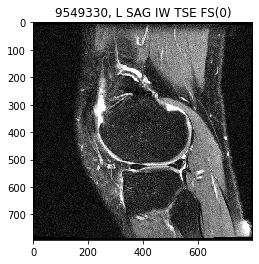

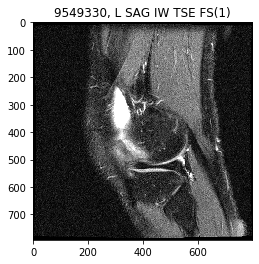

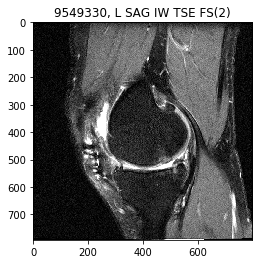

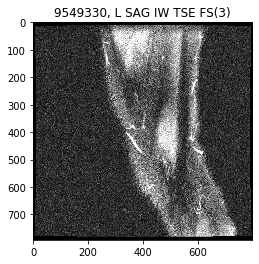

Row Index: 1981


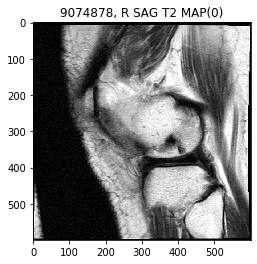

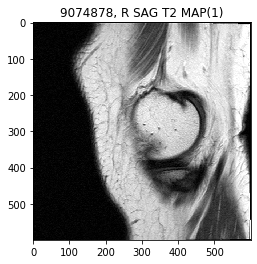

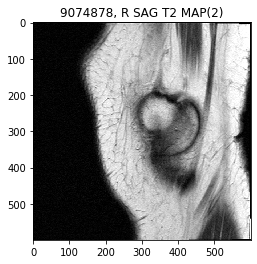

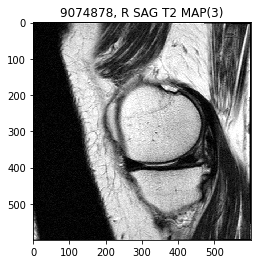

Row Index: 16217
Row Index: 27362


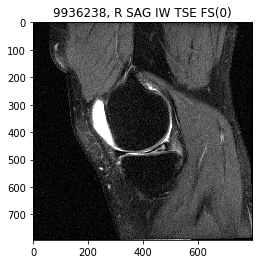

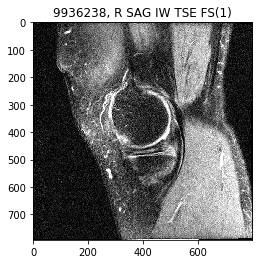

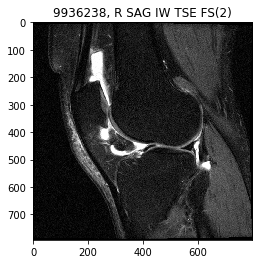

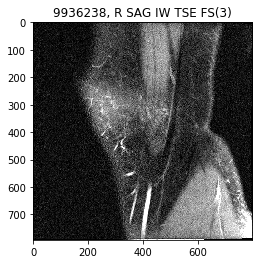

In [16]:
counter = 0
for i, row in samp_patient.iterrows():
    print("Row Index:", i)
    cohort = "C.2" if row["V00CHRTHLF"]== "1: First half of cohort" else "E.1" if row["V00CHRTHLF"] == "2: Second half of cohort" else np.nan

    try: date = row["V" + visit_str.format(0) + "MRDATE"].strftime("%Y%m%d")
    except:
        continue
    
    slices = retrieve_mri(row["ID"], cohort, date, 0, str(int(row["V00MRBARCD"]))[3:]) # Remove the 166 at beginning to get id
    
    for j, img_slice in enumerate(slices):
        if j > 3:
            break
        plt.imshow(img_slice, cmap="gray")
        plt.title(str(row.ID) + ", " + row.V00MEXAMTP + "(" + str(j) + ")")
        plt.show()
    counter += 1